# MatplotLib Animation Wrapper
---

## Imports
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MaxNLocator
import matplotlib
import numpy as np
import pandas as pd
import math
from easing_functions import *
import seaborn as sns
from matplotlib.dates import date2num
matplotlib.rcParams['animation.embed_limit'] = 2**128
from enum import Enum
from typing import Callable, Iterator, Union, Optional, List, NoReturn
import easing_functions
from IPython.display import HTML, display

In [2]:
def lerp(a: int, b: int, t: float) -> int:
    return int((a * (1.0 - t)) + (b * t))

def lerp_float(a: float, b: float, t: float) -> float:
    return (a * (1.0 - t)) + (b * t)

class Animation:
    
    """Constructs a MPLAnimation object
    duration -- The duration of the animation in milliseconds
    easing -- The easing function applied to the animation - see https://easings.net/ for examples
    animation_function -- The user defined function that drives the animation
    """
    def __init__(self,
                 start_time: int,
                 duration: int, 
                 easing_function: Callable[[float, float, float], float], 
                 animation_function: Callable[[float], NoReturn]):
        self._start_time = start_time
        self._duration = duration
        self._easing_function = easing_function()
        self._animation_function = animation_function
    
    @property
    def start_time(self):
        return self._start_time
    
    @start_time.setter
    def duration(self, start_time):
        self._start_time = start_time
    
    @property
    def duration(self):
        return self._duration
    
    @duration.setter
    def duration(self, duration):
        self._duration = duration
    
    @property
    def animation_function(self):
        return self._animation_function
    
    @property
    def easing_function(self):
        return self._easing_function

class Timeline:
    
    def __init__(self, animations: List[Animation], fig: matplotlib.figure.Figure, frames_per_second: int):
        self._animations = animations
        self._frames_per_second = frames_per_second
        self._duration = max(list(map(lambda x: x.start_time + x.duration, animations)))
        self._duration = self.__milliseconds_to_frames(self._duration, frames_per_second) + 1        
        self._animation = matplotlib.animation.FuncAnimation(fig, self.__animate, self._duration, init_func=lambda: None, interval=1000/frames_per_second)

    @staticmethod
    def __milliseconds_to_frames(milliseconds, frames_per_second) -> int:
        return math.ceil(milliseconds / (1000 / frames_per_second))
    
    @property
    def duration(self):
        return self._duration
    
    def __animate(self, i):
        for animation in self._animations:
            self.print_progress(i / self._duration)
            animation_start_frame = self.__milliseconds_to_frames(animation.start_time, self._frames_per_second)
            animation_end_frame = self.__milliseconds_to_frames(animation.duration, self._frames_per_second) + animation_start_frame
            if i >= animation_start_frame and i <= animation_end_frame:
                t = (i - animation_start_frame) / (animation_end_frame - animation_start_frame)
                t = animation.easing_function(t)
                animation.animation_function(t)
    
    def show_in_notebook(self):
        display(HTML(self._animation.to_jshtml()))
        
    def print_progress(self, progress: float):
        percent_complete = int(progress/1.0 * 100.0)
        message = "Rendering "
        total_bars = 20
        progress_int = int(progress * total_bars)
        remainder_int = int(total_bars - (progress * total_bars))
        progress_bars = ''.join(['▰' for x in range(progress_int)])
        remainder_bars = ''.join(['▱' for x in range(remainder_int)])
        progress_bar = progress_bars + remainder_bars
        message += progress_bar
        print(message + " " + str(percent_complete) + "%  ", end='\r')
        if percent_complete == 100:
            print('\n')

In [3]:
class LineDraw(Animation):
    
    """Constructs a MPLAnimationLineDraw object
    duration -- The duration of the animation in milliseconds
    easing -- The easing function applied to the animation - see https://easings.net/ for examples
    animation_function -- The user defined function that drives the animation
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 easing_function: Callable[[float, float, float], float], 
                 line: matplotlib.lines.Line2D,
                 x_data: list,
                 y_data: list,
                 start_index: int,
                 end_index: int):
        
        super().__init__(start_time, duration, easing_function, self._line_draw)

        self._line = line
        self._x_data = x_data
        self._y_data = y_data
        self._start_index = start_index
        self._end_index = end_index
        
    def _line_draw(self, t):
        index = lerp(self._start_index, self._end_index, t)
        self._line.set_data(self._x_data[:index], self._y_data[:index])
        
class MoveMarker(Animation):
    
    """Constructs a MPLAnimationLineDraw object
    duration -- The duration of the animation in milliseconds
    easing -- The easing function applied to the animation - see https://easings.net/ for examples
    animation_function -- The user defined function that drives the animation
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 easing_function: Callable[[float, float, float], float], 
                 marker: matplotlib.lines.Line2D,
                 x_data: list,
                 y_data: list,
                 start_index: int,
                 end_index: int):
        
        super().__init__(start_time, duration, easing_function, self._marker_move)

        self._marker = marker
        self._x_data = x_data
        self._y_data = y_data
        self._start_index = start_index
        self._end_index = end_index
        
    def _marker_move(self, t):
        index = lerp(self._start_index, self._end_index, t)
        index = index - 1 if index > 0 else 0
        self._marker.set_data(self._x_data[index], self._y_data[index])
        
class Autoscale(Animation):
    
    """Constructs a MPLAnimationAutoscale object
    duration -- The duration of the animation in milliseconds
    ax -- The axes that needs to autoscale
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 ax: matplotlib.axes):
        
        super().__init__(start_time, duration, LinearInOut, self._autoscale)
        
        self._ax = ax
        
    def _autoscale(self, t):
        self._ax.relim()
        self._ax.autoscale_view()

class ScaleX(Animation):
    
    """Constructs a MPLAnimationAutoscale object
    duration -- The duration of the animation in milliseconds
    ax -- The axes that needs to autoscale
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 ax: matplotlib.axes,
                 left: float,
                 right: float):
        
        super().__init__(start_time, duration, LinearInOut, self._scalex)
        
        self._ax = ax
        self._left = left
        self._right = right
        self._start_xlim = None
        
    def _scalex(self, t):
        self._start_xlim = ax.get_xlim() if self._start_xlim == None else self._start_xlim
        left = lerp_float(self._start_xlim[0], self._left, t)
        right = lerp_float(self._start_xlim[1], self._right, t)
        self._ax.set_xlim(left=left, right=right)
        

class ScaleY(Animation):
    
    """Constructs a MPLAnimationAutoscale object
    duration -- The duration of the animation in milliseconds
    ax -- The axes that needs to autoscale
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 ax: matplotlib.axes,
                 bottom: float,
                 top: float):
        
        super().__init__(start_time, duration, LinearInOut, self._scaley)
        
        self._ax = ax
        self._bottom = bottom
        self._top = top
        self._start_ylim = None
        
    def _scaley(self, t):
        self._start_ylim = ax.get_ylim() if self._start_ylim == None else self._start_ylim
        bottom = lerp_float(self._start_ylim[0], self._bottom, t)
        top = lerp_float(self._start_ylim[1], self._top, t)
        self._ax.set_ylim(bottom=bottom, top=top)
    
class AnnotateMovingMarker(Animation):

    """Constructs a MPLAnimationAutoscale object
    duration -- The duration of the animation in milliseconds
    ax -- The axes that needs to autoscale
    """
    def __init__(self, 
                 start_time: int,
                 duration: int,
                 easing_function: Callable[[float, float, float], float],
                 ax: matplotlib.axes,
                 annotation: matplotlib.text.Annotation,
                 x_data: list,
                 y_data: list,
                 start_index: int,
                 end_index: int,
                 y_text_position_pixels: int):
        
        super().__init__(start_time, duration, easing_function, self.__annotate_moving_marker)
        
        self._ax = ax
        self._annotation = annotation
        self._x_data = x_data
        self._y_data = y_data
        self._start_index = start_index
        self._end_index = end_index
        self._y_text_position_pixels = y_text_position_pixels
        
    def __annotate_moving_marker(self, t):
        index = lerp(self._start_index, self._end_index, t)
        index = index - 1 if index > 0 else 0
        xy_pos = (self._x_data[index], self._y_data[index])        
        xdisplay, ydisplay = ax.transData.inverted().transform((0,self._y_text_position_pixels))
        self._annotation.xy = xy_pos
        self._annotation.set_position((xy_pos[0], ydisplay))


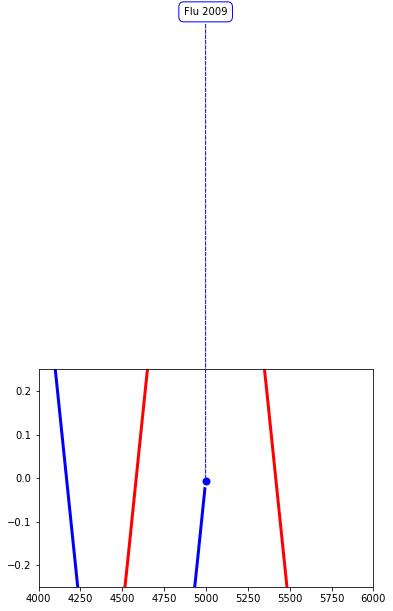

In [4]:
fig, ax = plt.subplots(1)
steps = 5000

sin_x = [x for x in range(steps)]
sin_y = [math.sin(x/steps * math.pi * 6) for x in range(steps)]
sin_line_plot, = ax.plot([], [], color="blue", linewidth=3)
sin_dot_plot, = ax.plot([],[], marker='o', color="blue", markersize=10, markeredgecolor="white", markeredgewidth=2)

cos_x = [x for x in range(steps*2)]
cos_y = [math.cos(x/steps * math.pi * 6) for x in range(steps*2)]
cos_line_plot, = ax.plot([], [], color="red", linewidth=3)
cos_dot_plot, = ax.plot([],[], marker='o', color="red", markersize=10, markeredgecolor="white", markeredgewidth=2)

annotation = ax.annotate("Flu 2009",
                            xy=(0,0), xycoords='data',
                            xytext=(0, 0), textcoords='data',
                            arrowprops=dict(arrowstyle="-", color='blue', linestyle='--'),
                            ha="center",
                            bbox=dict(facecolor='white', edgecolor='blue', boxstyle="round,pad=0.5"))

sin_line_draw = LineDraw(start_time=0, 
                         duration=1000, 
                         easing_function=SineEaseOut, 
                         line=sin_line_plot, 
                         x_data=sin_x, 
                         y_data=sin_y, 
                         start_index=0, 
                         end_index=(len(sin_x) - 1))

sin_dot_move = MoveMarker(start_time=0, 
                          duration=1000, 
                          easing_function=SineEaseOut, 
                          marker=sin_dot_plot, 
                          x_data=sin_x, 
                          y_data=sin_y, 
                          start_index=0, 
                          end_index=(len(sin_x) - 1))

cos_line_draw = LineDraw(start_time=500, 
                         duration=1000, 
                         easing_function=SineEaseOut, 
                         line=cos_line_plot, 
                         x_data=cos_x,
                         y_data=cos_y,
                         start_index=0,
                         end_index=(len(cos_x) - 1))

cos_dot_move = MoveMarker(start_time=500, 
                          duration=1000, 
                          easing_function=SineEaseOut, 
                          marker=cos_dot_plot, 
                          x_data=cos_x, 
                          y_data=cos_y, 
                          start_index=0, 
                          end_index=(len(cos_x) - 1))

autoscale = Autoscale(start_time=0, 
                                  duration=2500, 
                                  ax=ax)

scalex = ScaleX(start_time=2500, 
                duration=1000, 
                ax=ax,
                left=4000,
                right=6000)

scaley = ScaleY(start_time=2500, 
                duration=1000, 
                ax=ax,
                bottom=-0.25,
                top=0.25)

moving_marker = AnnotateMovingMarker(start_time=0, 
                                     duration=1000, 
                                     easing_function=SineEaseOut, 
                                     ax=ax,
                                     annotation=annotation,
                                     x_data=sin_x,
                                     y_data=sin_y,
                                     start_index=0, 
                                     end_index=(len(sin_x) - 1),
                                     y_text_position_pixels=250)

animation = Timeline([sin_line_draw, sin_dot_move, cos_line_draw, cos_dot_move, autoscale, scalex, scaley, moving_marker], fig, 60)
animation.show_in_notebook()